
## Project: Demystifying CRISP-DM with Seattle Airbnb Data
**Table of Contents **

1. Business Understanding
2.  Data Understanding
3.  Prepare Data
4.  Modeling
5. Evaluation


1. ** Business Understanding**
Finding an accomodation is the most typical problem to be solved, when travelling to other city or country. And one of the most important things in choosing an accomodation is the reservation price.
With the given dataset we will try to understand the following:-

**
What are the main factors, which affect the reservation prices?
** **
Does time of the year influence prices ? 
** **
what are the busiest times of the year to visit particular city?
** **
How can we save money on the reservation?
**

2. **Data Understanding**
In this section of the report, we will load in the data, check for cleanliness, and then trim and clean the dataset for analysis.



# **Gather the data **

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline
import plotly as py
from plotly.offline import iplot, plot, init_notebook_mode, download_plotlyjs
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.offline as offline
#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seattle/listings.csv
/kaggle/input/seattle/calendar.csv
/kaggle/input/seattle/reviews.csv


 # **Access**

**AirBnB provided us with 3 datasets for Seattle:**

1. listings.csv - summary information on listing in Seattle such as: location, host information, cleaning and guest fees, amenities etc.
2. calendar.csv - calendar data for the listings: availability dates, price for each date.
3. reviews.csv - summary review data for the listings. This dataset won't be used in further analysis.

In [3]:
#Loading the data 
calendar_data = pd.read_csv('/kaggle/input/seattle/calendar.csv', header = 0)
listings_data = pd.read_csv('/kaggle/input/seattle/listings.csv', header = 0)
reviews_data = pd.read_csv('/kaggle/input/seattle/reviews.csv', header = 0)

# Checking Null Values and datatypes for each column in dataset

In [4]:
#function for checking info and null values 
def information_function(df):
    '''
    input : a dataset
    
    output : 1) number of null values in the columns of the input dataset
    2) info of the columns of the input dataset
    '''
    print(df.isnull().sum())
    print(df.info())

**For Calendar_data **

In [5]:
information_function(calendar_data)

listing_id         0
date               0
available          0
price         459028
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB
None


**For listings Data**

In [6]:
information_function(listings_data)

id                                    0
listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   627
Length: 92, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-nu

**For Reviews Data**

In [7]:
information_function(reviews_data)

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB
None


#  Our first Question is how the price varies with date. For this we have to look at the calendar dataset.
There are 4 columns.  
Here, I found some charactoristics of the data.

* Not only available days are stored in data, it seems to be stored not available days.
* If the `available` values are `f`, the `price` values seems to be `NaN`. 
* The `price` values are stored as object, not integer. This is caused the value stored like `$xx.xx`, and it is necessary to transform this column.

# Data Preparation

# **Clean**

**For Calendar Data**

In [8]:
#removing the rows for which there is no values in price column.
calendar_data = calendar_data.dropna(subset = ['price'],axis = 0)
# now change the date to datetime object
calendar_data['date'] = pd.to_datetime(calendar_data['date'])
# initialize a dictionary that will change true to 1 and false to 0 in available column
dictionary = {'t': 1,'f':0}
calendar_data['available'] = calendar_data['available'].map(dictionary)
#removing th $ sign from price
calendar_data['price'] = calendar_data['price'].apply(lambda x: str(x).replace('$',''))
calendar_data['price'] = pd.to_numeric(calendar_data['price'], errors = 'coerce')
# apply aggregation
calendar_data = calendar_data.groupby('date')['price'].mean().reset_index()


**For Listings Data**

In [9]:
#Taking columns that might contribute in the price
df = listings_data.loc[:,[ 'city','host_response_time', 'host_response_rate', 
    'host_acceptance_rate', 'host_is_superhost','cleaning_fee', 
    'neighbourhood_group_cleansed', 'property_type', 'room_type', 
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
    'amenities', 'price', 'minimum_nights',
    'maximum_nights', 'instant_bookable',
    'cancellation_policy', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value']]

In [10]:
def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' INPUT : Dataframe,column_name and number of dummies
       Output:  Split values in columns, which contain lists (for example, amenities) 
    '''
    
    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)

In [11]:
# data preprocessing
#Recode host_response_time to integers as it is a spectrum
df['host_response_time'].replace('within an hour', 1, inplace=True)
df['host_response_time'].replace('within a few hours', 2, inplace=True)
df['host_response_time'].replace('within a day', 3, inplace=True)
df['host_response_time'].replace('a few days or more', 4, inplace=True)

#Impute missing values using forward-fill method
df['host_response_time'].fillna(method='ffill', inplace=True)
#Convert acceptance/response percentages to numbers
df['host_acceptance_rate'] = df['host_acceptance_rate'].replace('%','',regex=True).astype('float64')/100.00
df['host_response_rate'] = df['host_response_rate'].replace('%','',regex=True).astype('float64')/100.00

#Impute missing values using forward-fill method
df['host_response_rate'].fillna(method='ffill', inplace=True)
df['host_acceptance_rate'].fillna(method='ffill', inplace=True)
#Change f/t values to binary 0/1
df['host_is_superhost'].replace('t',1, inplace=True)
df['host_is_superhost'].replace('f',0, inplace=True)
df['instant_bookable'].replace('t',1, inplace=True)
df['instant_bookable'].replace('f',0, inplace=True)
#split amenities into dummy columns and drop the original column
split_list_into_columns(df, 'amenities')
df = df.drop(columns = ['amenities'])
#convert price to number and drop the price_x column
df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
#fill missing values for review scores columns
review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
for column in review_scores_columns:
    df[column].fillna(df[column].mean(), inplace = True)
#fill in missing values for bathrooms, bedrooms and beds with mode
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
df['host_is_superhost'].fillna(method='ffill', inplace=True)
df['property_type'].fillna(method = 'ffill',inplace = True)
df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '')
df['cleaning_fee'] = df['cleaning_fee'].str.replace(',', '').astype('float64')
df['cleaning_fee'].fillna(0, inplace=True)


In [12]:
#Converting the categorical variables to suitable numeric dtypes
#for cancellation policy
dictionary = {'moderate':0,'strict':1,'flexible':2}
df['cancellation_policy'] = df['cancellation_policy'].map(dictionary)
#for bed_type
dictionary = {'Real Bed':0,'Futon':1,'Pull-out Sofa':2,'Airbed':3,'Couch':4}
df['bed_type'] = df['bed_type'].map(dictionary)
#for property_type
def decode(value):
    if value not in ['House', 'Apartment', 'Touwnhouse', 'Condominium']:
        return 'Other'
    return value

df['property_type'] = df['property_type'].apply(decode)
dictionary = {'House':0,'Apartment':1,'Touwnhouse':2,'Condominium':3,'Other':4}
df['property_type'] = df['property_type'].map(dictionary)
#for city 
#def decode(value):
 #   if value not in ['Ballard, Seattle', 'Seattle', 'West Seattle ', 'seattle']:
  #      return 'Other'
   # return value
#df['city'] = df['city'].apply(decode)
#dictionary = {'Ballard, Seattle':0, 'Seattle':1, 'West Seattle':2, 'seattle':3,'Other':4}
#df['city'] = df['city'].map(dictionary)
# for room type 
dictionary = {'Entire home/apt':0, 'Private room':1, 'Shared room':2}
df['room_type'] = df['room_type'].map(dictionary)

# **Visualization of data for creating insights from data**

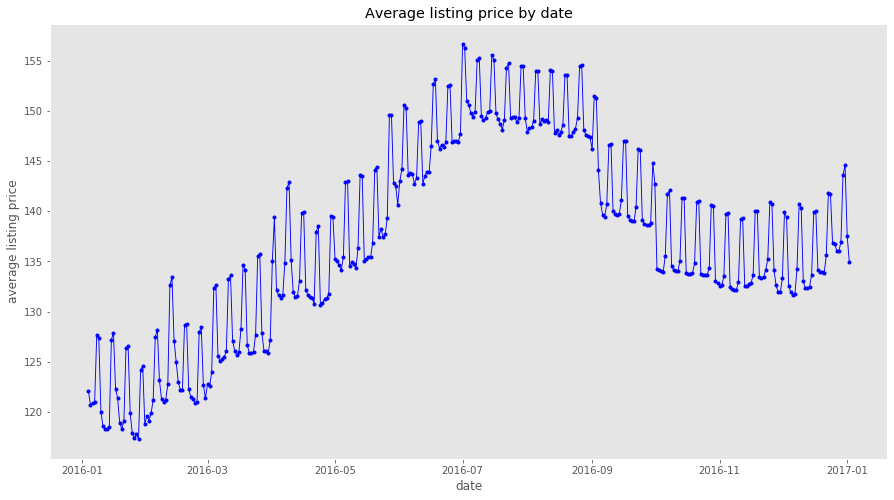

In [13]:
# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(calendar_data.date, calendar_data.price, color='b', marker='.', linewidth=0.9)
plt.title("Average listing price by date")
plt.xlabel('date')
plt.ylabel('average listing price')
plt.grid()

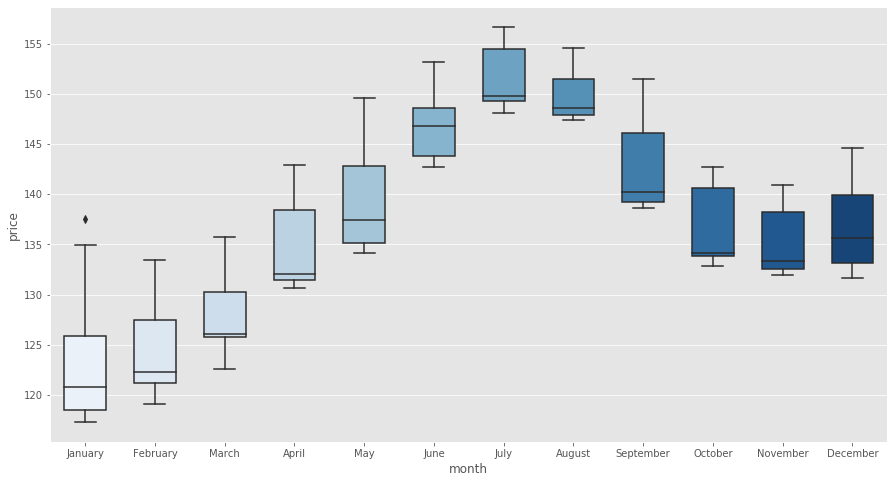

In [14]:
#How the price varies with month.
# create month column
calendar_data["month"] = calendar_data["date"].dt.month_name()

# boxplot to see price distribution
plt.figure(figsize=(15, 8))
hm = sns.boxplot(x = 'month',  y = 'price', data = calendar_data, palette="Blues", width=0.6)
plt.show()
fig = hm.get_figure()
fig.savefig('month vs price.png')

 From the above plot we can conclude that the peak month is from June to August when the price is high.

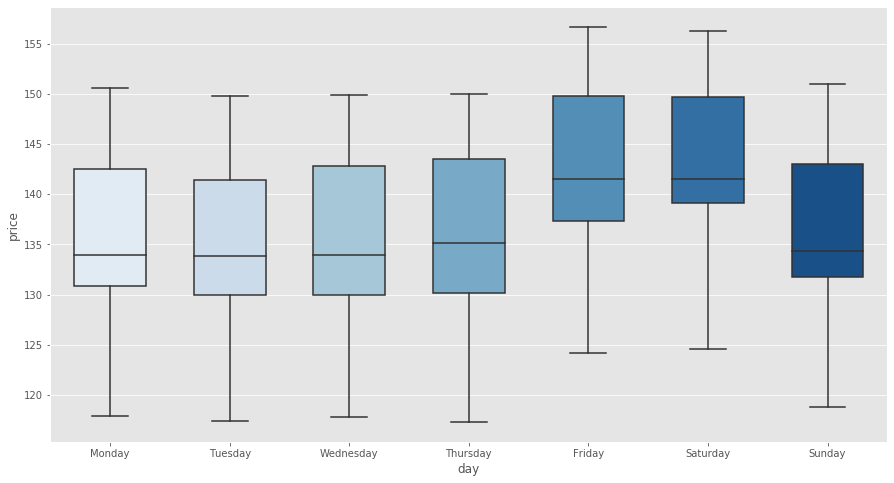

In [15]:
# Now plot the graph with respect to weekday to see dependence of price over the days
# create month column
calendar_data["day"] = calendar_data["date"].dt.day_name()

# boxplot to see price distribution
plt.figure(figsize=(15, 8))
hm = sns.boxplot(x = 'day',  y = 'price', data = calendar_data, palette="Blues", width=0.6)
plt.show()
fig = hm.get_figure()
fig.savefig('day vs price.png')

From the above plot we can conclude that the price is higher on weekends

# Variation of Price with respect to city


In [16]:
city_data = df.groupby('city')['price']
city_data.mean()

city
Ballard, Seattle         116.000000
Phinney Ridge Seattle     60.000000
Seattle                  128.052231
Seattle                   97.500000
West Seattle             110.000000
seattle                  105.000000
西雅图                       38.000000
Name: price, dtype: float64

Looking at the data below you can see that there are three columns with the name seattle. One was capitalized, and in the cell above as I lower-cased each string, they become the same. The third one is in Chinese characters. Despite being the same city, the mean values for price are wildly different.

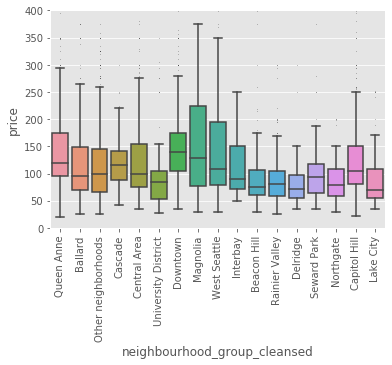

In [17]:
ax = sns.boxplot(data=df, x='neighbourhood_group_cleansed', y='price', fliersize=0.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(0, 400);
fig = ax.get_figure()
fig.savefig('neighbour vs price.png')

Dependence of all other columns with respect to price

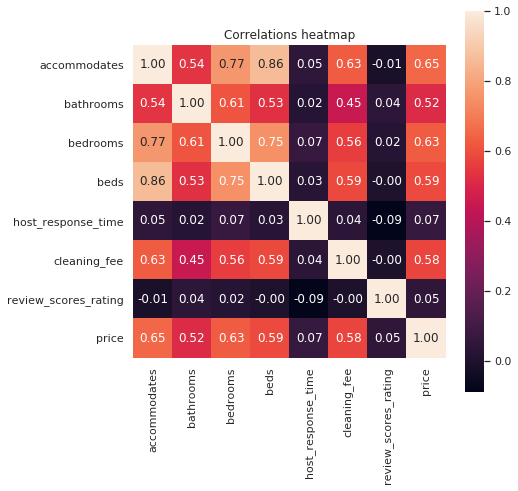

In [18]:
#Numerical columns to find out correlation
cols =  ['accommodates','bathrooms','bedrooms','beds',
        'host_response_time','cleaning_fee', 
        'review_scores_rating', 'price']
#Find out correlation between columns and plot
corrs = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

fig = hm.get_figure()
fig.savefig('correlations.png')

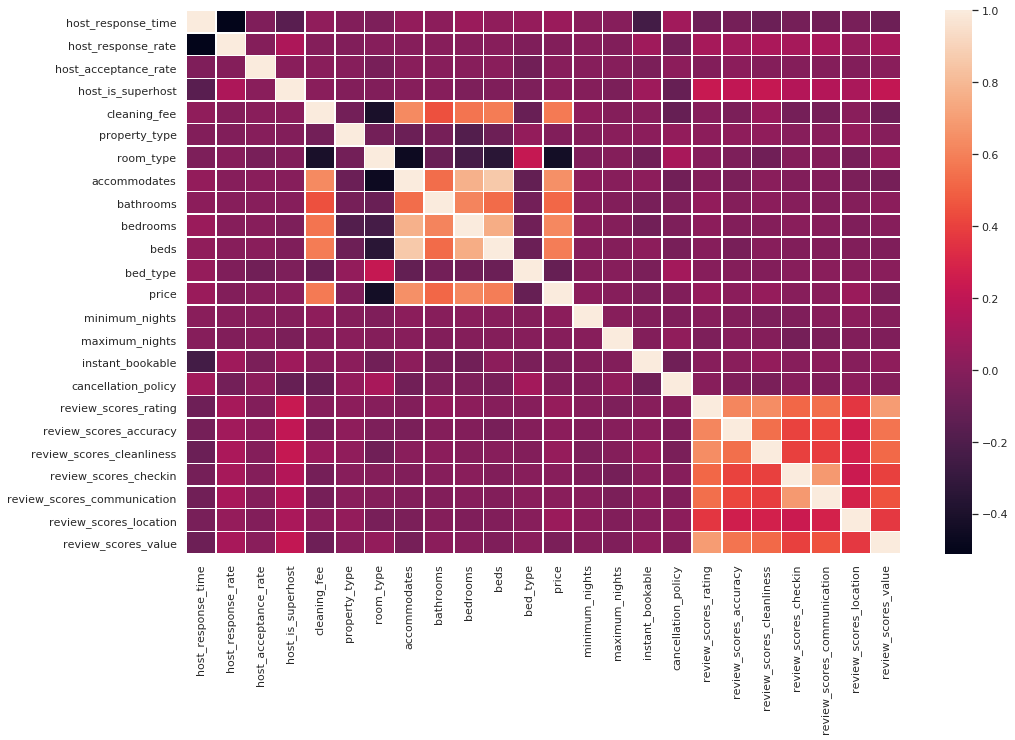

In [19]:
#Correlation Matrix
fig, ax = plt.subplots(figsize=(16,10))
corr = df.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, linewidths=.5, ax=ax)
corr['price'].sort_values(ascending=False)
fig = hm.get_figure()
fig.savefig('correlations1.png')

# Modelling 

In [20]:
#Getting dummy variable for data
df = pd.get_dummies(df, columns=['neighbourhood_group_cleansed','city'])

**Train test split of the data**

In [21]:
#Create Training / Test splits
from sklearn.model_selection import train_test_split

target_name = 'price'
X = df.drop('price', axis=1)
y= df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=42)

**Using Random Forest for training**

In [23]:
#train RF regressor model
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)



# Analysis of Model Performance

In [24]:
print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 497.821, test: 3007.000
Random Forest R^2 train: 0.938, test: 0.647


# Visualization of Important Features 

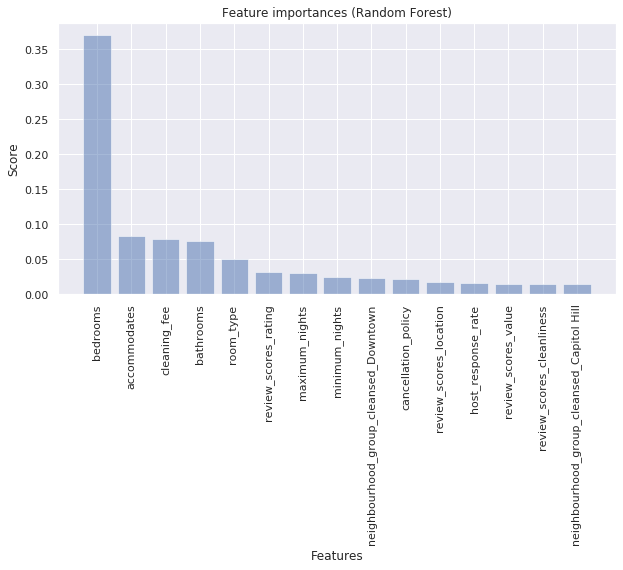

In [25]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

# conclusion
The main takeaways of the Seattle data analysis include:
* Basic characteristics of the place (number of bedrooms, bathrooms, beds and accomodates) affect the reservation price.
* The reservation price varies depending on the time of the year. For example, the busiest time to visit Seattle is summer.
* The Price is higher on the weekends.
* The host qualities and the number of reviews and review scores might also affect the reservation price. That is why if you want to save money, you may, for example, look for places which have fewer reviews. This will help to find the places with same characteristics (bathrooms, bedrooms, location etc.), and lower reservation price.
